## 언어 모델링 위한 트랜스포머 모델 만들기!
언어 모델링
특정 언어 시퀀스(Sequence)가 주어질 때 그 뒤를 따르는 단어나 단어 시퀀스 발생 확률을 알아내기

### 언어 모델링

- 확률론적/통계적 기술을 사용하여 언어를 모델링하여 계산

- 특정 말이 나올 때 어떤 단어들이 함께 나오고, 어떤 것은 절대 나오지 않는지를 학습

- 챗봇, 기계 번역, 내용요약, STT(Speech to Text) 등 사용


### 트랜스포머 모델 , Attention is All You Need

- encoder-decoder 구조의 seqence to seqence 모델
- RNN 기반 모델의 단점을 극복
    - 순서대로 처리하는 RNN 메커니즘상, 시퀀스가 길어질 수록 연산시간이 길어짐
- 모든 토큰 동시에 입력 받아 병렬 연산 -> GPU 연산 최적화
- Attention 메커니즘을 극대화




#### 트랜스포머의 구조


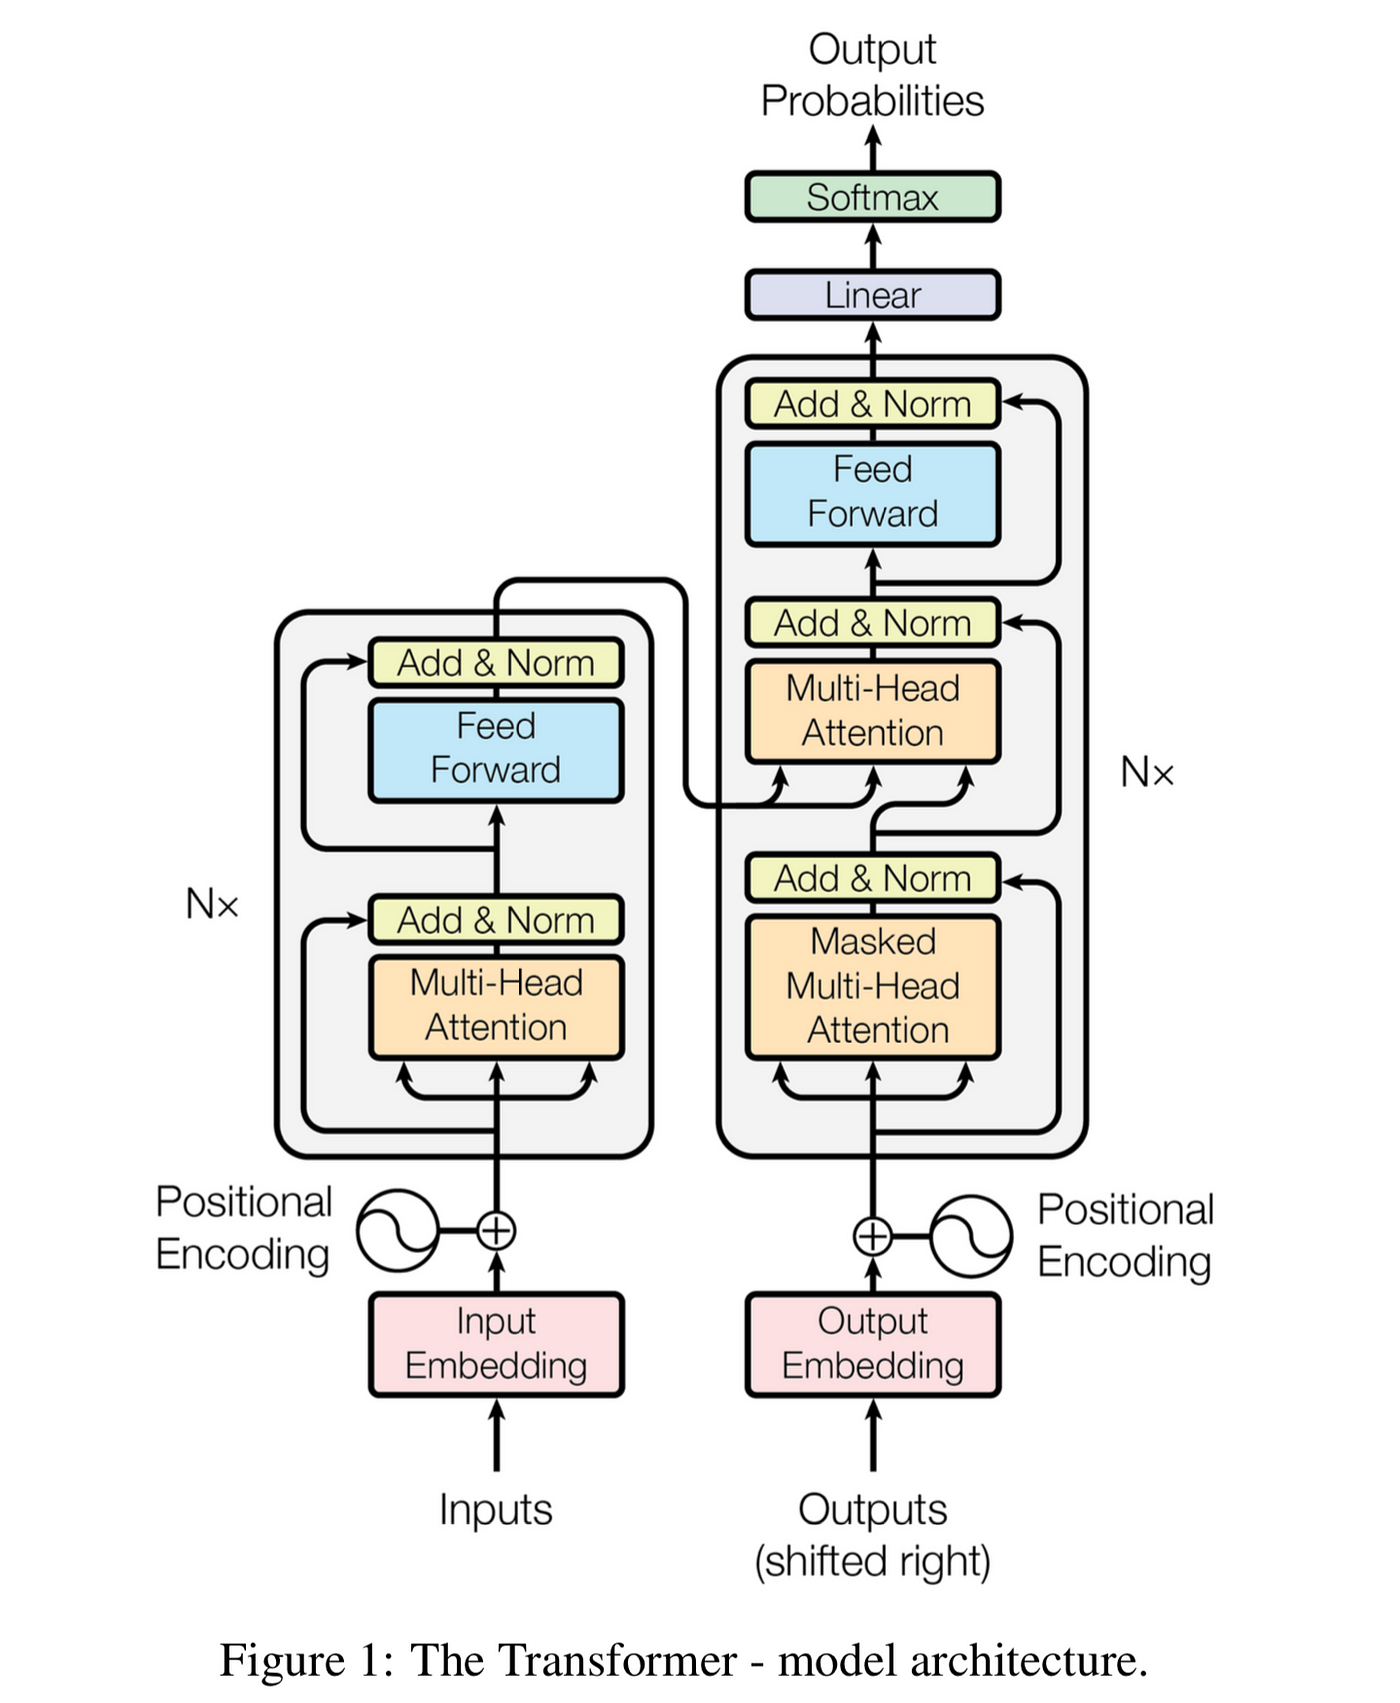

#### 위치 인코딩(Positional Encoding)

- 병렬화 위하여 모든 단어 정보를 동시에 입력
- 언어는 시계열 데이터기 때문에 순서가 중요
- 단어의 상대적인 위치 정보를 제공하기 위하여 **Positional Encoding** 작업을 수행
    - input data의 size에 상관없이 output 도출 필요
    - 모델의 효율적 학습을 위해 제한된 범위 안에 존재 필요
     
     --> 차원별로 번갈아가며 sin, cos 이용하여 위치 정보 인코딩


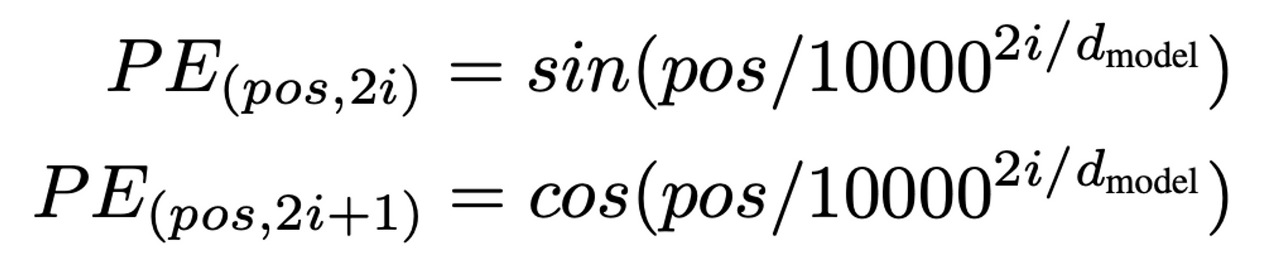

컴퓨터는 it을 어떻게 추측할 수 있을까??

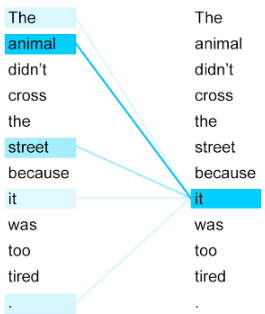

#### Self-Attention 매커니즘
1. 쿼리(Q)행렬과 키(K) 행렬 내적 -> Attention Score

2. 결과로 나오는 행렬의 요소를 √dk 로 나눔 (dk: Q,K,V 벡터 차원) -> 계산 보정 목적

3. 행렬 각 요소에 softmax

4. 밸류(V) 행렬과 내적

**Query** : 분석하고자 하는 단어에 대한 가중치 벡터

**Key**: 각 단어가 쿼리에 해당하는 단어와 얼마나 연관있는 지를 비교하기 위한 가중치 벡터

**Value**: 각 단어의 의미를 살려주기 위한 가중치 벡터

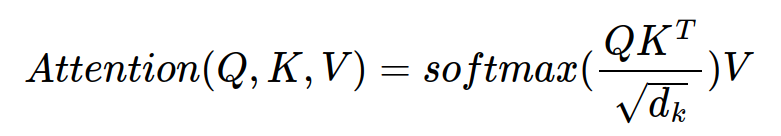

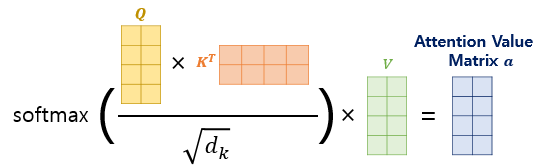

#### Multi-head Attention
- Self- Attention을 동시에 병렬적으로 실행
- 도출된 Attention Value들은 마지막에 concatenate를 통해 하나로
- 여러 개를 나누어 병렬 계산하는 Multi-head Attention 메커니즘이 성능이 더 좋다.(Google research)

#### Multi-head Attention 메커니즘

1. Query, Key, Value 행렬 값을 head 수만큼 분할
2. 분할된 행렬 값을 통해, 각 Attention value값들을 도출
3. 도출된 Attention value값들을 concatenate(쌓아 합치기)하여 최종 Attention value 도출

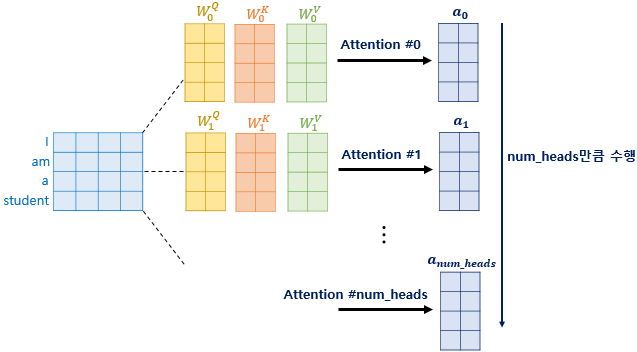

#### 덧셈과 계층 정규화(Layer Normalization & Skip Connection)
- Layer normalization: Batch normalization와 유사
- Skip connection(Residual connection): 역전파 과정에서 정보 소실 방지


#### 순전파 계층(Feed Forward Neural Network)
- Hidden layer가 늘어났다가 다시 원래 차원으로 축소, 단순 2층 신경망
- Recurrnt 구조가 없음 -> 결국, RNN 개념과 상반

#### Masked Self-Attention
- 디코더 블록에서 사용되는 특수한 Self-Attention
- 디코더는 Auto-Regressive하게 단어를 생성
- 미래 시점의 단어들을 참고하지 못하게 하는 것이 목적
- 타깃 단어 이후로 단어를 보지 않고 단어를 예측
- 타깃 단어 뒤에 위치한 단어는 Self-Attention에 영향을 주지 않도록 **마스킹(masking)**
- Softmax를 취해주기 전, 가려주고자 하는 요소에만  -∞ 에 해당하는 매우 작은 수 합산
- 마스킹된 값은 Softmax를 취해 주었을 때 0이 나오므로 Value 계산 미반영

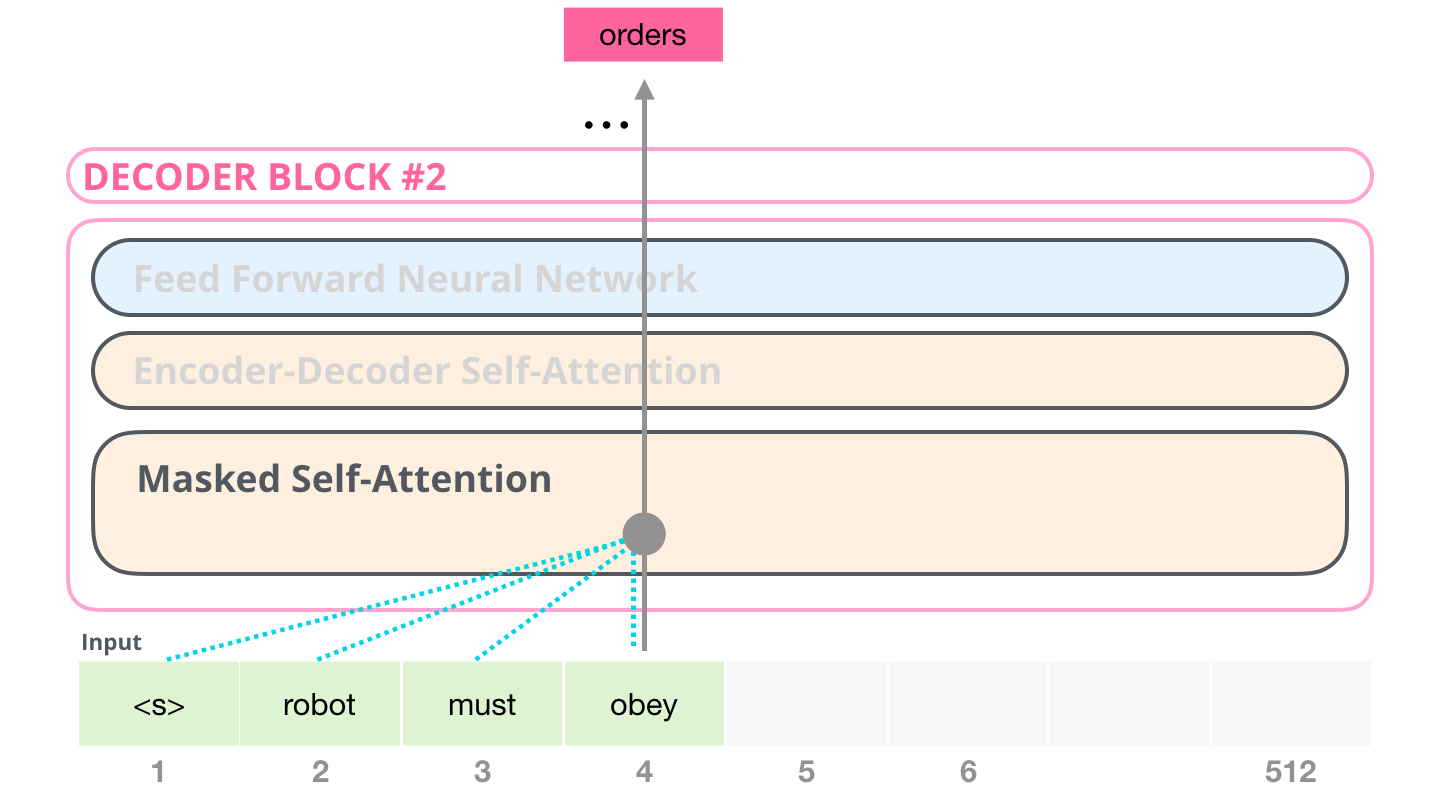

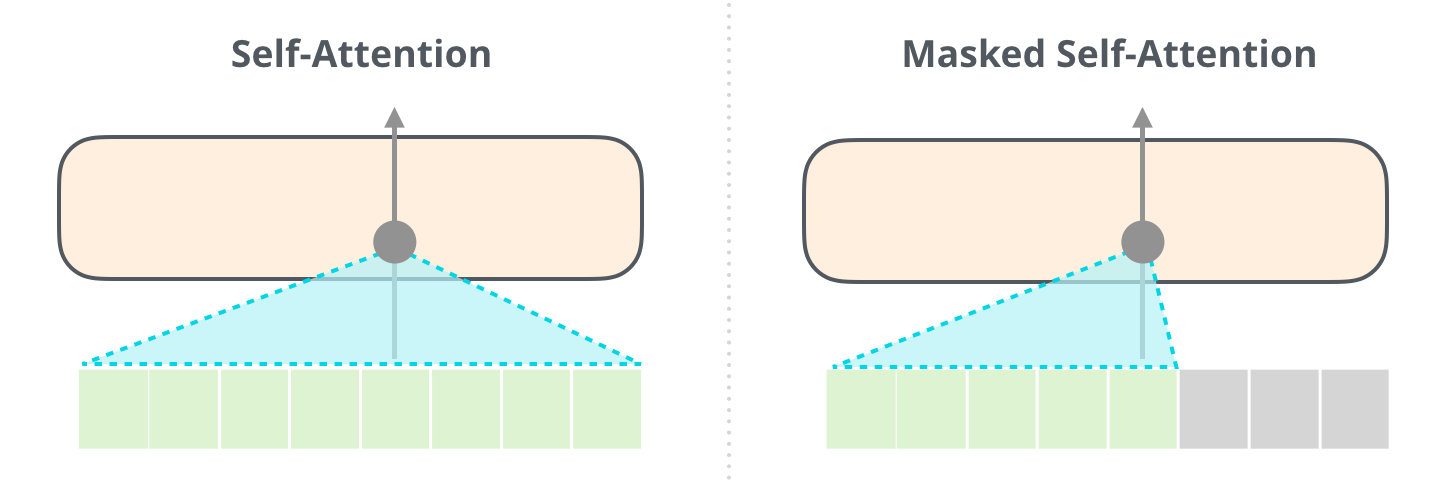

#### Encoder-Decoder Attention
- 쿼리는 Masked Self-Attention으로부터 출력데이터 사용
- 키,밸류는 인코더에서 가져온 데이터 그대로 사용
- 나머지 계산 과정은 인코더와 동일

#### 선형 및 소프트맥스 계층(Linear & Softmax Layer)
- 선형 계층: 벡터 시퀀스를 단일 벡터로 변환
- 소프트맥스 계층: 각 단어의 시퀀스의 다음 단어로 나올 확률 벡터로 변환(총합 1)

### 트랜스포머 모델 실습

In [1]:
# 라이브러리 불러오기
import math
import os
from tempfile import TemporaryDirectory
from typing import Tuple

import torch
from torch import nn, Tensor
import torch.nn.functional as F
from torch.nn import TransformerEncoder, TransformerEncoderLayer # 트랜스포머 특화 라이브러리
from torch.utils.data import dataset

In [2]:
# 모델 정의

class TransformerModel(nn.Module):

    def __init__(self, ntoken: int, d_model: int, nhead: int, d_hid: int,
                 nlayers: int, dropout: float = 0.5):
        super().__init__()
        self.model_type = 'Transformer'
        self.pos_encoder = PositionalEncoding(d_model, dropout)
        encoder_layers = TransformerEncoderLayer(d_model, nhead, d_hid, dropout)
        self.transformer_encoder = TransformerEncoder(encoder_layers, nlayers)
        self.encoder = nn.Embedding(ntoken, d_model)
        self.d_model = d_model
        self.decoder = nn.Linear(d_model, ntoken)

        self.init_weights()

    def init_weights(self) -> None:
        initrange = 0.1
        self.encoder.weight.data.uniform_(-initrange, initrange)
        self.decoder.bias.data.zero_()
        self.decoder.weight.data.uniform_(-initrange, initrange)

    def forward(self, src: Tensor, src_mask: Tensor) -> Tensor:
        """
        Arguments:
            src: Tensor, shape ``[seq_len, batch_size]``
            src_mask: Tensor, shape ``[seq_len, seq_len]``

        Returns:
            output Tensor of shape ``[seq_len, batch_size, ntoken]``
        """
        src = self.encoder(src) * math.sqrt(self.d_model)
        src = self.pos_encoder(src)
        output = self.transformer_encoder(src, src_mask)
        output = self.decoder(output)
        return output


def generate_square_subsequent_mask(sz: int) -> Tensor:
    """Generates an upper-triangular matrix of ``-inf``, with zeros on ``diag``."""
    return torch.triu(torch.ones(sz, sz) * float('-inf'), diagonal=1)

In [3]:
# 포지션 인코더
class PositionalEncoding(nn.Module):

    def __init__(self, d_model: int, dropout: float = 0.1, max_len: int = 5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x: Tensor) -> Tensor:
        """
        Arguments:
            x: Tensor, shape ``[seq_len, batch_size, embedding_dim]``
        """
        x = x + self.pe[:x.size(0)]
        return self.dropout(x)

In [ ]:
# 데이터 로드
%%bash
#pip install torchdata
#pip install 'portalocker>=2.0.0'

In [5]:
#데이터셋 로드 및 배치
from torchtext.datasets import WikiText2 #데이터셋
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

train_iter = WikiText2(split='train')
tokenizer = get_tokenizer('basic_english')
vocab = build_vocab_from_iterator(map(tokenizer, train_iter), specials=['<unk>']) # 보기 드문 토큰을 <unk>로 표시
vocab.set_default_index(vocab['<unk>'])

def data_process(raw_text_iter: dataset.IterableDataset) -> Tensor:
    """Converts raw text into a flat Tensor."""
    data = [torch.tensor(vocab(tokenizer(item)), dtype=torch.long) for item in raw_text_iter]
    return torch.cat(tuple(filter(lambda t: t.numel() > 0, data)))

# ``train_iter`` was "consumed" by the process of building the vocab,
# so we have to create it again
train_iter, val_iter, test_iter = WikiText2()
train_data = data_process(train_iter)
val_data = data_process(val_iter)
test_data = data_process(test_iter)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def batchify(data: Tensor, bsz: int) -> Tensor:
    """Divides the data into ``bsz`` separate sequences, removing extra elements
    that wouldn't cleanly fit.

    Arguments:
        data: Tensor, shape ``[N]``
        bsz: int, batch size

    Returns:
        Tensor of shape ``[N // bsz, bsz]``
    """
    seq_len = data.size(0) // bsz
    data = data[:seq_len * bsz]
    data = data.view(bsz, seq_len).t().contiguous()
    return data.to(device)

batch_size = 20
eval_batch_size = 10
train_data = batchify(train_data, batch_size)  # shape [seq_len, batch_size]
val_data = batchify(val_data, eval_batch_size)
test_data = batchify(test_data, eval_batch_size)


In [7]:
# 입력-타겟 시퀀스 쌍 생성
bptt = 35
def get_batch(source: Tensor, i: int) -> Tuple[Tensor, Tensor]:
    """
    Arguments:
        source: Tensor, shape ``[full_seq_len, batch_size]``
        i: int

    Returns:
        tuple ``(data, target)``, where data has shape ``[seq_len, batch_size]`` and
        target has shape ``[seq_len * batch_size]``
    """
    seq_len = min(bptt, len(source) - 1 - i)
    data = source[i:i+seq_len]
    target = source[i+1:i+1+seq_len].reshape(-1)
    return data, target

In [8]:
# 하이퍼 파라미터 정의
ntokens = len(vocab) # 단어 사전(어휘집)의 크기
emsize = 200 # 임베딩 차원
d_hid = 200 # ``nn.TransformerEncoder`` 에서 피드포워드 네트워크(feedforward network) 모델의 차원
nlayers = 2 # ``nn.TransformerEncoder`` 내부의 nn.TransformerEncoderLayer 개수
nhead = 2 # ``nn.MultiheadAttention`` 의 헤드 개수
dropout = 0.2 # 드랍아웃(dropout) 확률
model = TransformerModel(ntokens, emsize, nhead, d_hid, nlayers, dropout).to(device)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [9]:
# 모델 시작
import copy
import time

criterion = nn.CrossEntropyLoss()
lr = 5.0  # 학습률(learning rate)
optimizer = torch.optim.SGD(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.95)

def train(model: nn.Module) -> None:
    model.train()  # 학습 모드 시작
    total_loss = 0.
    log_interval = 200
    start_time = time.time()
    src_mask = generate_square_subsequent_mask(bptt).to(device)

    num_batches = len(train_data) // bptt
    for batch, i in enumerate(range(0, train_data.size(0) - 1, bptt)):
        data, targets = get_batch(train_data, i)
        seq_len = data.size(0)
        if seq_len != bptt:  # 마지막 배치에만 적용
            src_mask = src_mask[:seq_len, :seq_len]
        output = model(data, src_mask)
        loss = criterion(output.view(-1, ntokens), targets)

        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
        optimizer.step()

        total_loss += loss.item()
        if batch % log_interval == 0 and batch > 0:
            lr = scheduler.get_last_lr()[0]
            ms_per_batch = (time.time() - start_time) * 1000 / log_interval
            cur_loss = total_loss / log_interval
            ppl = math.exp(cur_loss)
            print(f'| epoch {epoch:3d} | {batch:5d}/{num_batches:5d} batches | '
                  f'lr {lr:02.2f} | ms/batch {ms_per_batch:5.2f} | '
                  f'loss {cur_loss:5.2f} | ppl {ppl:8.2f}')
            total_loss = 0
            start_time = time.time()

def evaluate(model: nn.Module, eval_data: Tensor) -> float:
    model.eval()  # 평가 모드 시작
    total_loss = 0.
    src_mask = generate_square_subsequent_mask(bptt).to(device)
    with torch.no_grad():
        for i in range(0, eval_data.size(0) - 1, bptt):
            data, targets = get_batch(eval_data, i)
            seq_len = data.size(0)
            if seq_len != bptt:
                src_mask = src_mask[:seq_len, :seq_len]
            output = model(data, src_mask)
            output_flat = output.view(-1, ntokens)
            total_loss += seq_len * criterion(output_flat, targets).item()
    return total_loss / (len(eval_data) - 1)

In [10]:
best_val_loss = float('inf')
epochs = 2

with TemporaryDirectory() as tempdir:
    best_model_params_path = os.path.join(tempdir, "best_model_params.pt")

    for epoch in range(1, epochs + 1):
        epoch_start_time = time.time()
        train(model)
        val_loss = evaluate(model, val_data)
        val_ppl = math.exp(val_loss)
        elapsed = time.time() - epoch_start_time
        print('-' * 89)
        print(f'| end of epoch {epoch:3d} | time: {elapsed:5.2f}s | '
            f'valid loss {val_loss:5.2f} | valid ppl {val_ppl:8.2f}')
        print('-' * 89)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), best_model_params_path)

        scheduler.step()
    model.load_state_dict(torch.load(best_model_params_path)) # load best model states

| epoch   1 |   200/ 2928 batches | lr 5.00 | ms/batch 833.42 | loss  8.21 | ppl  3683.97
| epoch   1 |   400/ 2928 batches | lr 5.00 | ms/batch 872.20 | loss  6.89 | ppl   978.26
| epoch   1 |   600/ 2928 batches | lr 5.00 | ms/batch 858.34 | loss  6.44 | ppl   627.98
| epoch   1 |   800/ 2928 batches | lr 5.00 | ms/batch 896.27 | loss  6.31 | ppl   550.58
| epoch   1 |  1000/ 2928 batches | lr 5.00 | ms/batch 808.36 | loss  6.20 | ppl   492.41
| epoch   1 |  1200/ 2928 batches | lr 5.00 | ms/batch 820.50 | loss  6.16 | ppl   474.12
| epoch   1 |  1400/ 2928 batches | lr 5.00 | ms/batch 892.65 | loss  6.11 | ppl   452.37
| epoch   1 |  1600/ 2928 batches | lr 5.00 | ms/batch 936.78 | loss  6.11 | ppl   450.62
| epoch   1 |  1800/ 2928 batches | lr 5.00 | ms/batch 874.59 | loss  6.03 | ppl   415.75
| epoch   1 |  2000/ 2928 batches | lr 5.00 | ms/batch 935.87 | loss  6.02 | ppl   411.53
| epoch   1 |  2200/ 2928 batches | lr 5.00 | ms/batch 999.79 | loss  5.89 | ppl   362.31
| epoch   

In [11]:
# 모델 평가
test_loss = evaluate(model, test_data)
test_ppl = math.exp(test_loss)
print('=' * 89)
print(f'| End of training | test loss {test_loss:5.2f} | '
      f'test ppl {test_ppl:8.2f}')
print('=' * 89)

| End of training | test loss  5.57 | test ppl   261.66


### BERT 모델
- Bidirectional Encoder Representation by Transformer
- 트랜스포머의 인코더만을 사용하여 문맥을 양방향으로 읽음
- 사전 학습된 언어 모델(Pre-trained Language Model)의 일종
    - 레이블링이 되지 않은 데이터를 모델이 학습
    - 전이 학습(Transfer Learning) 이라고도 불림
    - 감성 분석, 자연어 추론(NLI), 질의 응답(QA) 등 사용





#### 모델 구조
- 12개의 인코더 블록 축척
    - Special Token
        - CLS: Classification
            - 입력 최상단 존재
            - NSP(Next Sentence Prediction) 학습위해 존재

        - SEP: Sepration
            - 1,2 부분 끝자리에 존재
    - Input Vector: 세 종류의 임베딩 벡터를 모두 더해 모델에 입력
        - Token Embeddings : 단어 임베딩. Word2Vec, GloVe, FastText 사전 학습된 임베딩 벡터 사용
        - Segment Embeddings : 첫 번째 부분과 두 번째 부분을 구분하기 위한 임베딩, CLS ~ 첫번째SEP, 그 다음토큰 ~ 두번째SEP 별로 나눠 벡터 적용
        - Position Embeddings: 단어의 위치를 나타내기 위한 임베딩

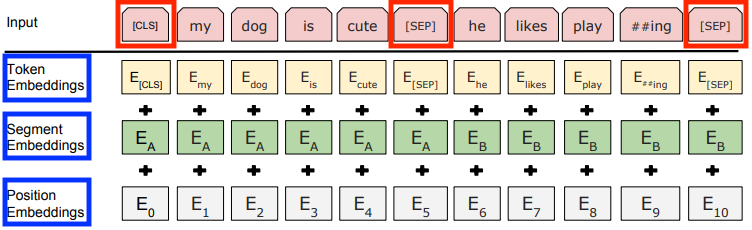

#### BERT의 사전 학습(Pre-training) 방법
1. MLM(Masked Language Model)
    - '빈칸 채우기'를 하면서 단어를 학습
    - 레이블링 되지 않은 말뭉치 중 랜덤으로 약 15% 단어 마스킹
    - 마스킹 위치에 원래 있던 단어를 예측하는 방식으로 학습
    - 앞뒤 문맥을 동시에 볼 수 있는 장점
2. NSP(Next Sentence Prediction)
    - 동문서답을 하는지를 판단
    - 두 문장이 이어질 때, CLS 토큰 출력이 IsNext 로 되도록 학습
    - 두 문장이 이어지지 않는 쌍일 경우에는 출력 벡터가 NotNext 로 나오도록 학습